# Extract clips from Xenocanto Snapshot (including negatives)

In [ ]:
from pathlib import Path
from tqdm.autonotebook import tqdm
import pandas as pd
import datasets
from pathlib import Path

# Make sure to dont change this, otherwise you will donwload the whole dataset again
cache_dir = "/media/kiwi/datasets/annotated/xeno_canto_snapshot/data_cache" 
ds = datasets.load_dataset(
    "DBD-research-group/BirdSet",
    "XCL",
    cache_dir=cache_dir, 
)
t = ds["train"]

print("The number of recordings in the dataset is", len(t))

Using the latest cached version of the dataset since DBD-research-group/BirdSet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'XCL' at /media/kiwi/datasets/annotated/xeno_canto_snapshot/data_cache/DBD-research-group___bird_set/XCL/0.0.4/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Wed Oct 22 13:54:41 2025).


The number of recordings in the dataset is 528422


## Change first line depending of your target species

In [71]:
target="Chestnut-backed Antbird"

# Read the file line by line and skip rows that cause decode errors
import io

#Clements taxonomy available at: https://www.birds.cornell.edu/clementschecklist/wp-content/uploads/2024/10/Clements-v2024-October-2024-rev.xlsx
ebird_path = "/media/auk/projects/srg/Kitzes_projects/ECOO53_LaSelva_Loca/ebird_codes.txt"
good_lines = []
with open(ebird_path, "rb") as f:
    for line in f:
        try:
            good_lines.append(line.decode("utf-8"))
        except UnicodeDecodeError:
            continue

ebird_df = pd.read_csv(io.StringIO(''.join(good_lines)), sep="\t")
target_row = ebird_df[ebird_df["English name"] == target]
target_row

,species_code,English name,scientific name
12611,chbant1,Chestnut-backed Antbird,Poliocrania exsul


## Subset snapshot to recordings with your target species

In [ ]:
# Make a new dataset object with just your target species recordings
target_ebird_code=str(target_row['species_code'].values[0])
label_feature = t.features["ebird_code"]

farewell_int = label_feature.str2int(target_ebird_code) 
filtered = t.filter(lambda example: example["ebird_code"] == farewell_int)

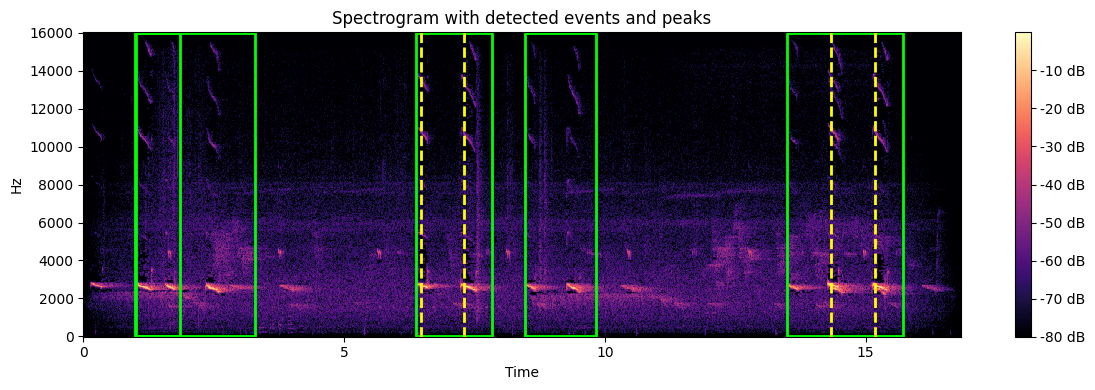

[[0.992, 3.296], [1.008, 1.856], [6.368, 7.84], [8.464, 9.824], [13.488, 15.712]]
[6.475168280552686, 7.290201044844545, 14.327401619626327, 15.187090716887516]


In [69]:
# Access an example
example = filtered[1]

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio from the .ogg file
audio_path = example["filepath"]
y, sr = librosa.load(audio_path, sr=None)

# Calculate the spectrogram (mel or linear, up to you; use linear here)
S = librosa.stft(y, n_fft=1024, hop_length=256)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Set up the axes for time for drawing detected_events and peaks
duration = librosa.get_duration(y=y, sr=sr)
times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=256, n_fft=1024)

fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='hz', ax=ax)
plt.colorbar(img, ax=ax, format="%+2.0f dB")
ax.set_title("Spectrogram with detected events and peaks")

# Draw rectangles for each detected event [start, end]
for ev in example.get("detected_events", []):
    start, end = ev
    ax.add_patch(
        plt.Rectangle(
            (start, 0),  # (x,y)
            end - start,
            sr // 2,    # full frequency range (or np.max(S_db.shape[0]))
            color='lime',
            linewidth=2,
            fill=False
        )
    )

# Draw vertical lines for each peak
for peak in example.get("peaks", []):
    ax.axvline(peak, color='yellow', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

print(example["detected_events"])

print(example["peaks"])
from IPython.display import Audio, display

display(Audio(example['filepath']))

## Parameters you need to set before calling the audio files

In [70]:
#  TARGET SPECIES
# Duration of clips to extract
clip_duration = 3

# Maximum number of events to extract (based on peaks)
max_events = 20

#  NEGATIVE SPECIES
# Maximum number of events to extract (based on peaks)
neg_max_events = 3

# Geographic filter for negative class (change this to your study area)
lat_min, lat_max = 8, 11
lon_min, lon_max = -85, -82

In [ ]:
target = []
negatives=[]
for i in tqdm(range(len(t))):
    file = t[i]
    # optionally, filter by quality rating or negatives metadata
    if file['ebird_code'] == farewell_int:

    # if file['quality'] not in ['A','B']:  # Change this to filter by quality rating
    #     continue
        detected_events = file["detected_events"].copy()

        if len(detected_events) < 1:
            # no detections: use beginning of audio file
            detected_events = [[0, clip_duration]]
        elif len(detected_events) > max_events:
            # use up to 5 first
            detected_events = file["detected_events"][:max_events]

        for j, (start, end) in enumerate(detected_events):
            record = {
                "file": file["filepath"],
                "start_time": start,
                "annotation": file["ebird_code"],
                "quality": file['quality'],
            }
            target.append(record)

    # Convert the negatives sounds from Xenocanto to a OpenSoundscape format
    
    elif (file["ebird_code"] != farewell_int
        and lat_min <= file["lat"] <= lat_max
        and lon_min <= file["long"] <= lon_max):
    
        detected_events = file["detected_events"].copy()
        
        if len(detected_events) < 1:
            # no detections: use beginning of audio file
            detected_events = [[0, clip_duration]]
        elif len(detected_events) > 3:
            # use up to 5 first
            detected_events = file["detected_events"][:neg_max_events]

        for j, (start, end) in enumerate(detected_events):
            record_other = {
                "file": file["filepath"],
                "start_time": start,
                "annotation": file["ebird_code"],
                "quality": file['quality'],
            }
            negatives.append(record_other)
        # break


  0%|          | 0/528422 [00:00<?, ?it/s]

In [ ]:
target_df = pd.DataFrame(target)
negative_df = pd.DataFrame(negatives)

# convert integer annotation to list of one annotation per row
# this is the format used by annotations.categorical_to_multi_hot
target_df["annotation_list"] = [[x] for x in target_df["annotation"]]
negative_df["annotation_list"] = [[x] for x in negative_df["annotation"]]

In [50]:
target_df.head(5)

,file,start_time,annotation,quality,annotation_list
0,/media/kiwi/datasets/annotated/xeno_canto_snap...,0.576,4356,B,[4356]
1,/media/kiwi/datasets/annotated/xeno_canto_snap...,9.232,4356,B,[4356]
2,/media/kiwi/datasets/annotated/xeno_canto_snap...,0.992,4356,A,[4356]
3,/media/kiwi/datasets/annotated/xeno_canto_snap...,1.008,4356,A,[4356]
4,/media/kiwi/datasets/annotated/xeno_canto_snap...,6.368,4356,A,[4356]


In [33]:
negative_df.head(5)

,file,start_time,annotation,quality,annotation_list
0,/media/kiwi/datasets/annotated/xeno_canto_snap...,0.240,15,B,[15]
1,/media/kiwi/datasets/annotated/xeno_canto_snap...,2.096,15,B,[15]
2,/media/kiwi/datasets/annotated/xeno_canto_snap...,6.832,15,B,[15]
3,/media/kiwi/datasets/annotated/xeno_canto_snap...,0.752,22,C,[22]
4,/media/kiwi/datasets/annotated/xeno_canto_snap...,5.200,22,C,[22]
